In [54]:
import argparse
from pprint import pp
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import json
import os
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from utils import load_dataset, load_config
from utils import get_model
from utils import get_loss_hparams_and_lr, get_loss
from utils import trainer
from utils import utils
import matplotlib.pyplot as plt

In [55]:
#set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#code in this file will serve as a denoising test of the trained ne_lpn model

dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"



In [56]:
def run_test(network_type, scale_factor, model_path, dataset_config_path, model_weight_path):
    # load model and dataset
    model_config = load_config(model_path)
    model = get_model(model_config)
    model.load_state_dict(torch.load(model_weight_path)["model_state_dict"])

    dataset_config = load_config(dataset_config_path)
    test_dataset = load_dataset(dataset_config, "test")

    #get the data loader
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=4
    )

    # test for batches and apply guassian noise to each
    for step, batch in enumerate(test_data_loader):
        clean_images = batch["image"].to(device)
        output_clean = model(clean_images)
        mse_loss_clean = nn.MSELoss()
        #loss_clean = mse_loss_clean(clean_images, output_clean)

        scaled_images = clean_images * scale_factor
        output_scaled = model(scaled_images)
        mse_loss = nn.MSELoss()
        loss = mse_loss(scaled_images, output_scaled)

        if step == 0:
            #plot the four images ( using matplotlib
            fig, axs = plt.subplots(2, 2)
            axs[0, 0].imshow(clean_images[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[0, 0].set_title('Clean Image Unscaled')
            axs[0, 0].axis('off')
            axs[0, 1].imshow(output_clean[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[0, 1].set_title('Output Models Unscaled')
            axs[0, 1].axis('off')
            axs[1, 0].imshow(scaled_images[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[1, 0].set_title('Output Models Scaled')
            axs[1, 0].axis('off')
            axs[1, 1].imshow(output_scaled[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[1, 1].set_title('Clean Image Scaled')
            axs[1, 1].axis('off')
            plt.show()
            #save the figure
            if not os.path.exists("scaling_experiment"):
                os.makedirs("scaling_experiment")
            fig.savefig(f"scaling_experiment/{network_type}_scale_{scale_factor}.png")

            #test scaled output vs unscaled output using mse
            mse_loss = nn.MSELoss()
            loss = mse_loss(output_clean, output_scaled)
            print(f"Loss between scaled and unscaled output for network {network_type} and scale {scale_factor}: {loss.item()}")
            break

    return loss

In [57]:
ne_model_config_path = "../exps/mnist/configs/mnist/model_ne.json"
ne_model_weight_path = "../exps/mnist/experiments/ne_mnist/model.pt"
lpn_model_config_path = "../exps/mnist/configs/mnist/model.json"
lpn_model_weight_path = "../exps/mnist/experiments/mnist/model.pt"
dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"

init weights


dataset:  mnist


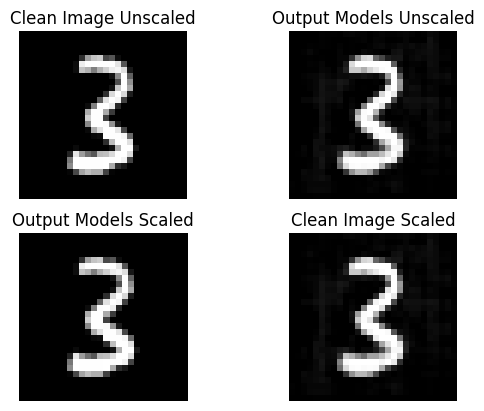

Loss between scaled and unscaled output for network ne and scale 1: 0.0
init weights
dataset:  mnist


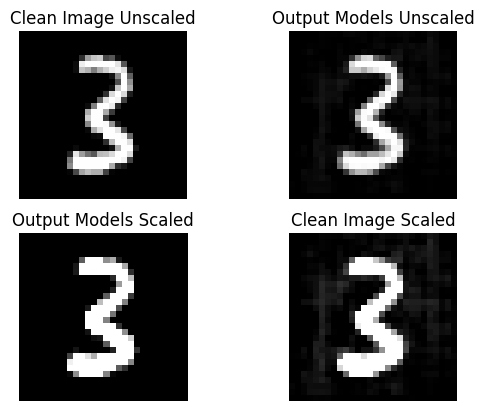

Loss between scaled and unscaled output for network ne and scale 2: 0.09929368644952774
init weights
dataset:  mnist


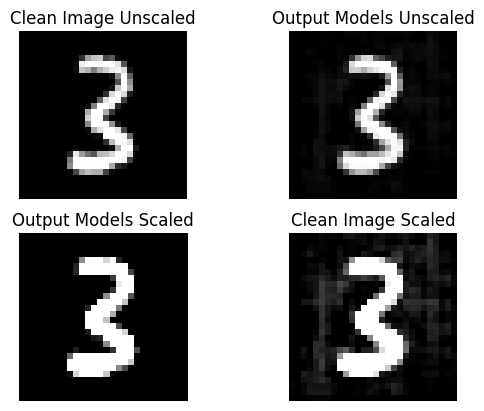

Loss between scaled and unscaled output for network ne and scale 3: 0.3971744775772095
init weights
dataset:  mnist


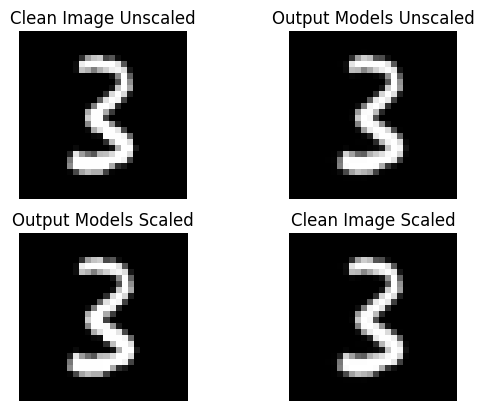

Loss between scaled and unscaled output for network lpn and scale 1: 0.0
init weights
dataset:  mnist


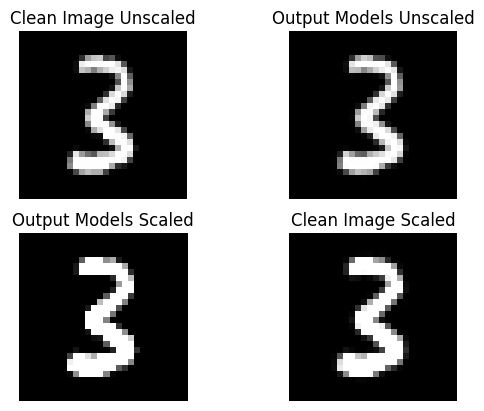

Loss between scaled and unscaled output for network lpn and scale 2: 0.009342257864773273
init weights
dataset:  mnist


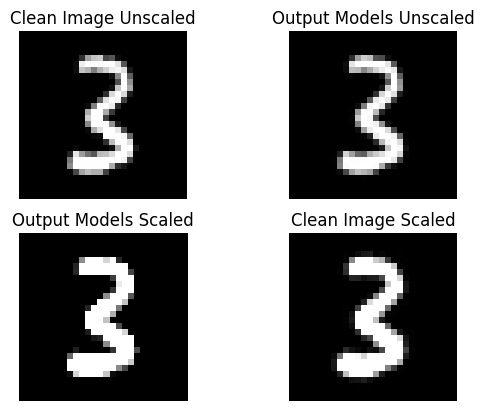

Loss between scaled and unscaled output for network lpn and scale 3: 0.017275311052799225


tensor(0.0173, grad_fn=<MseLossBackward0>)

In [58]:
run_test("ne", 1, ne_model_config_path, dataset_config_path, ne_model_weight_path)
run_test("ne", 2, ne_model_config_path, dataset_config_path, ne_model_weight_path)
run_test("ne", 3, ne_model_config_path, dataset_config_path, ne_model_weight_path)

run_test("lpn", 1, lpn_model_config_path, dataset_config_path, lpn_model_weight_path)
run_test("lpn", 2, lpn_model_config_path, dataset_config_path, lpn_model_weight_path)
run_test("lpn", 3, lpn_model_config_path, dataset_config_path, lpn_model_weight_path)